In [20]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
import os
import stumpy
from scipy import interpolate

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# Discovering motifs under uniform scaling
This tutorial explores the "Discovering motifs under uniform scaling" case study from the research paper:  
[The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do with the Matrix Profile and Ten Lines of Code (see Section 3.1)"](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf).[1]

### What is similarity we discuss here?
Time series motifs are approximately repeated patterns found within the data.  
For many data mining areas, the detection of such repeated patterns(similarity) is of essential importance.  
You can find similar sequence `A` and `B` below. How do you think about similarity of those?

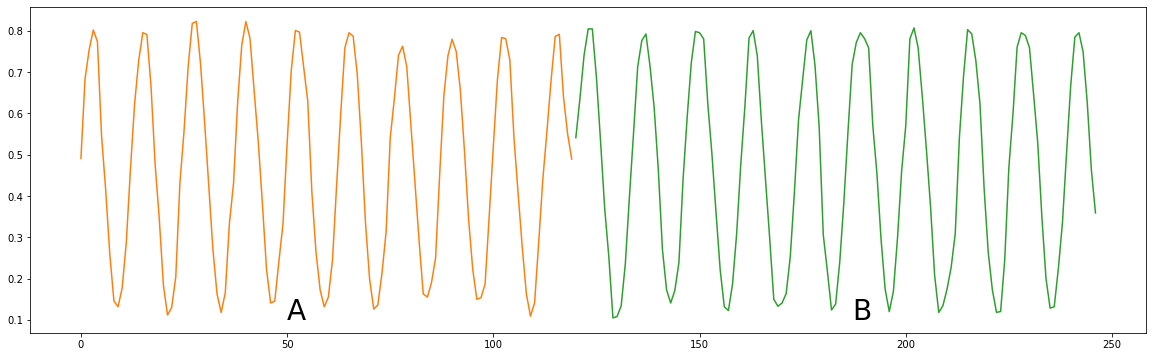

In [21]:
T = pd.read_csv("https://github.com/TDAmeritrade/stumpy/files/10027291/yankov.csv", index_col=0).iloc[:, 0].values
x = np.array(range(len(T)))

m_a, m_b = 120, 127
idx_a, idx_b = 120, 405
T_A, T_B = T[idx_a:idx_a+m_a], T[idx_b:idx_b+m_b]

plt.plot(np.arange(0, m_a), T_A, color="C1")
plt.plot(np.arange(m_a, m_a+m_b), T_B, color="C2")
plt.text(50, 0.1, "A", fontsize=28)
plt.text(187, 0.1, "B", fontsize=28)
plt.show()

It looks `A` and `B` are identical. Are they really identical?  
Let's plot `A` and `B` on top of each other to make sure they are identical.

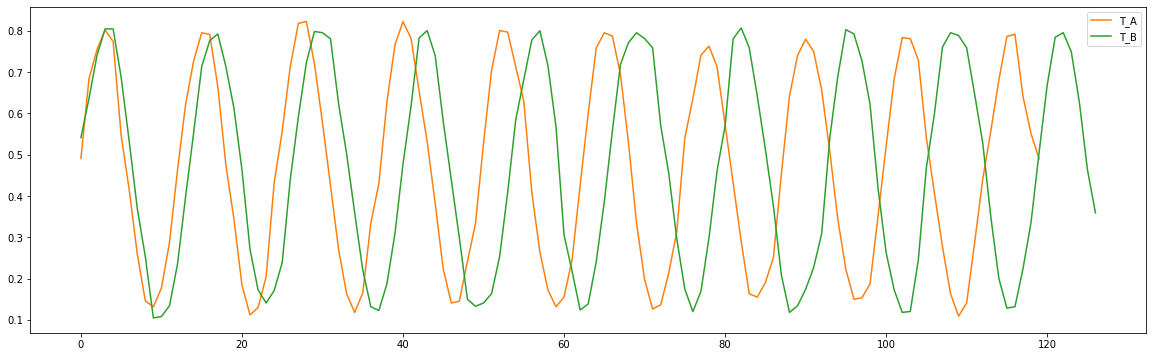

In [22]:
plt.plot(T_A, color="C1", label="T_A")
plt.plot(T_B, color="C2", label="T_B")
plt.legend()
plt.show()

`A` and `B` are almost "same shape" signal, but actually they are far from identical.  
If you compute the Euclidean distance between `A` and `B`, then they'd have a large Euclidean distance between them.  
Large euclidean distance is yielded gradually, so **cumulative euclidean distance** is good indicator to understand well.  

Let's plot `A` and `B` with cumulative euclidean distance.

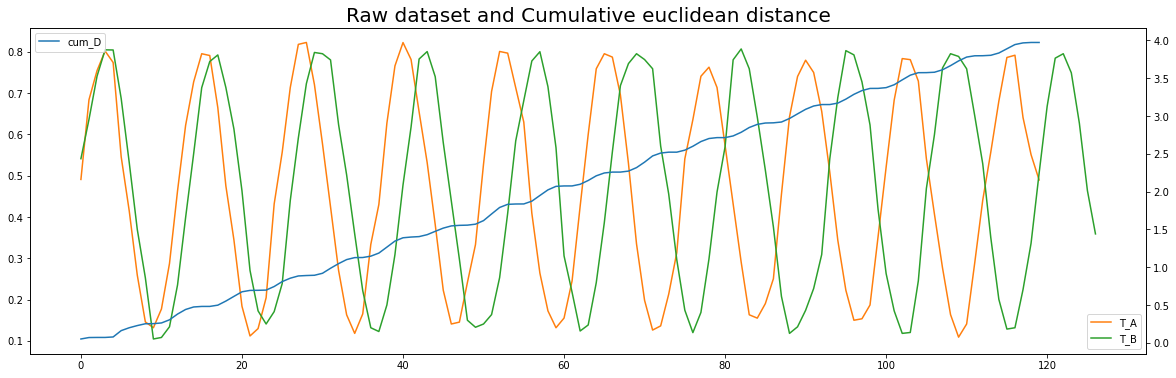

In [23]:
# cumulative euclidean distance
cum_D_raw = []
for i in range(1, m_a+1):
    cum_D_raw.append(np.linalg.norm(T_A[:i]-T_B[:i]))

ax1 = plt.axes()
ax1.plot(T_A, color="C1", label="T_A")
ax1.plot(T_B, color="C2", label="T_B")
plt.legend(loc=4)

ax2 = ax1.twinx()
ax2.plot(cum_D_raw, label="cum_D")
plt.title("Raw dataset and Cumulative euclidean distance", fontsize=20)
plt.legend(loc=2)
plt.show()

### What is unifrom scaling?
`A` and `B` can be almost identical by using **unifom scaling** (stretching/compressing).  
Those series are said to be **out-of-phase** with each other.  
`A` and `B` have a large Euclidean distance, itt means it can't detect `A` and `B` as top-motif by using Euclidean distance.

1. How does **uniform scaling** solve this problem?  
If you could figure out the best way to stretch/compress(**unifom scaling**) A or B so as to best match the locations of the peaks/valleys,  
then the Euclidean distance between `A` and `B` would become smaller. 

2. How about **uniform scaling** calculation?   
Insted of directrly computing Euclidean distance on time series A: $T_A$ and B: $T_B$, scale one of $T_A$ and $T_B$ at the first.
Here we have, scaling can be computed by `scipy.interpolate`.  
Its function creates model to interpolate signals, the model make **streching and compressing signal** possible.  
In this notebook, we adopt **nearest neighbor interpolation** as the easiest and fastest calculation way.  
If we can prepare scaled $T_A$ ( $T_A^{scaled}$ ), euclidean distance calculation itself is completly same with $T_A^{scaled}$ and $T_B$.  
All that's left is to define search range for scaling factor.

Let's find best scale factor to minimize cumulative distance. As search range is `100% ~ 150%`.

In [24]:
range_scaling = np.arange(1.0, 1.5, 0.01)
x_Ta = np.arange(m_a)
fitted_curve = interpolate.interp1d(x_Ta, T_A, kind='nearest')

D = []  # euclidean distance
for i_scale in range_scaling:
    x_dummy = np.linspace(0, m_a-1, int(m_a*i_scale))
    T_As = fitted_curve(x_dummy)
    if len(T_As) >= len(T_B):
        D.append(np.linalg.norm(T_As[:len(T_B)]-T_B))
    else:
        D.append(np.linalg.norm(T_As-T_B[:len(T_As)]))

# scaled series re-calculation
scale_factor = range_scaling[np.argmin(D)]
x_dummy = np.linspace(0, m_a-1, int(m_a*scale_factor))
T_As = fitted_curve(x_dummy)

# cumulative euclidean distance 
cum_D_scaling = []
for i in range(1, m_b+1):
    cum_D_scaling.append(np.linalg.norm(T_As[:i]-T_B[:i]))

D_raw = cum_D_raw[-1]  # euclidian distance raw
D_scaling = cum_D_scaling[len(cum_D_raw)]  # euclidian distance scaling

print(f"scaling factor for minimum Euclidean distance is {scale_factor:.2f}")
print(f"Euclidean distance is improved to {D_scaling:.3f} from {D_raw:.3f} ({((D_raw-D_scaling)/D_raw)*100:.2f}% improved)")

scaling factor for minimum Euclidean distance is 1.06
Euclidean distance is improved to 0.858 from 3.972 (78.40% improved)


By scaling by `6%`, cumulative distance is improved `78.40%`.  
The distance is improved dramatically, it seems A should be phase with B now.  

Let's plot scaled dataset and compare how the distance is changed.

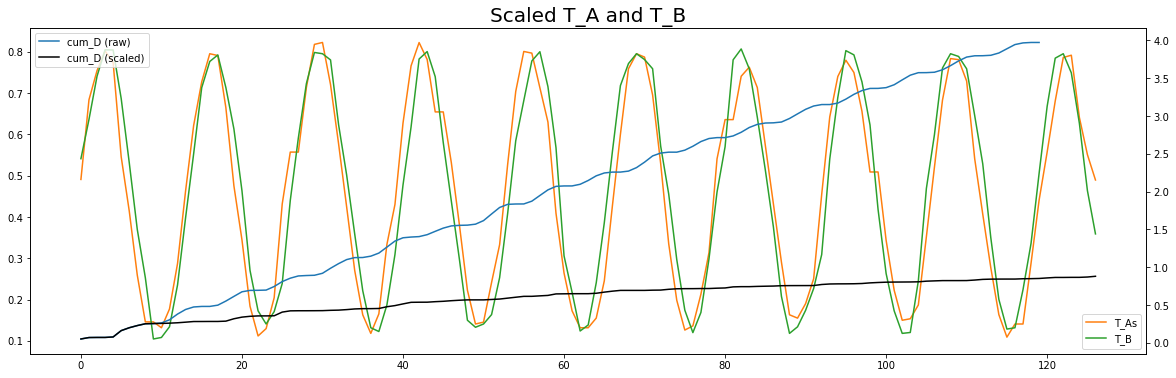

In [25]:
ax1 = plt.axes()
ax1.plot(T_As, color="C1", label="T_As")
ax1.plot(T_B, color="C2", label="T_B")
plt.legend(loc=4)

ax2 = ax1.twinx()
ax2.plot(cum_D_raw, label="cum_D (raw)")
ax2.plot(cum_D_scaling, label="cum_D (scaled)", color="k")
plt.title("Scaled T_A and T_B", fontsize=20)
plt.legend(loc=2)
plt.show()

As you can see above, $T_A^{scaled}$ is phase with $T_B$ well. Therefore cumulative distance doesn't increase along the time axis.  
Now you can find $T_A$ and $T_B$ as best distance by **uniform scaling** with euclidean distance.

## Uniform scaling with Matrix Profile

Scaling logic above can be appiled to Matrix Profile simply.  
Here is a random walk time series for demostration from the MALLAT dataset and Matrix profile caluculation by `stumpy.stump`.  
After checking "normal" Matrix profile, Let's demonstrate how uniform scaling affects the detecting motif .

In [26]:
T = pd.read_csv("https://github.com/TDAmeritrade/stumpy/files/10027290/MALLAT.csv", index_col=0).iloc[:, 0].values
m = 1024  # window size

l = len(T)
x = np.arange(l)
mp = stumpy.stump(T, m)
idx_a = np.argmin(mp[:, 0])
idx_b = mp[:, 1][idx_a]

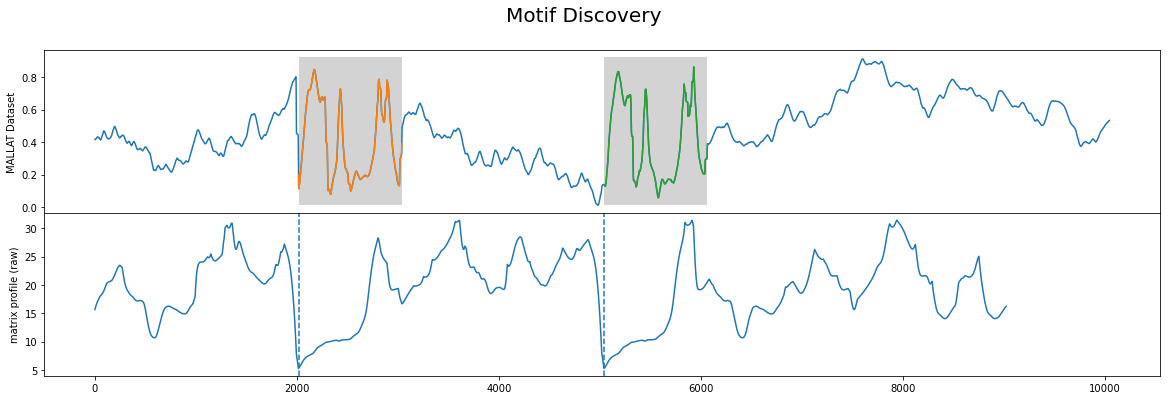

In [27]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery', fontsize='20')
axs[0].plot(T)
axs[0].plot(x[idx_a:idx_a+m], T[idx_a:idx_a+m])
axs[0].plot(x[idx_b:idx_b+m], T[idx_b:idx_b+m])
axs[0].set_ylabel("MALLAT Dataset")
rect = Rectangle((idx_a, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((idx_b, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)

axs[1].plot(mp[:, 0])
axs[1].axvline(idx_a, linestyle="dashed")
axs[1].axvline(idx_b, linestyle="dashed")
axs[1].set_ylabel("matrix profile (raw)")
plt.show()

The color highlighting indicates top-1 motif, which unsurprisingly are exactly the imbedded patterns.  
The matrix profile corresponding to the random walk time series. The minimum values correspond to the top-1 motif in the time series.

Let's demonstrate how unifrom scaling can affect motif discovery in **streching case(1)** and **compressing case(2)**.

### 1. Streching
The searched scaling range is `160% ~ 200%` as an illustrative example.

In [28]:
range_scaling = np.arange(1.6, 2.0, 0.01)
l_ = len(T) - m + 1

P_updated = np.full(l_, np.inf, dtype=np.float64)
I_updated = np.zeros(l_, dtype=np.float64)
minScale = np.full(l_, np.nan, dtype=np.float64)

x_T = np.arange(len(T))
fitted_curve = interpolate.interp1d(x_T, T, kind="nearest")

# Search scaling factor
for scale_factor in range_scaling:
    x_dummy = np.linspace(0, len(T)-1, int(len(T)*scale_factor))
    Ts = fitted_curve(x_dummy)
    mp = stumpy.stump(T, m, Ts, ignore_trivial=False)
    mask = mp[:, 0] < P_updated
    P_updated[mask] = mp[mask, 0]
    I_updated[mask] = mp[mask, 1]
    minScale[mask] = scale_factor

idx_min = np.argmin(P_updated)

# stretched series re-calculation
scale_factor = minScale[idx_min]
x_dummy = np.linspace(0, len(T)-1, int(len(T)*scale_factor))
Ts = fitted_curve(x_dummy)
x_Ts = np.arange(len(Ts))

idx_min_s = int(I_updated[idx_min])

print(f"Best motif is found by scaling factor {scale_factor:.2f}")

Best motif is found by scaling factor 1.88


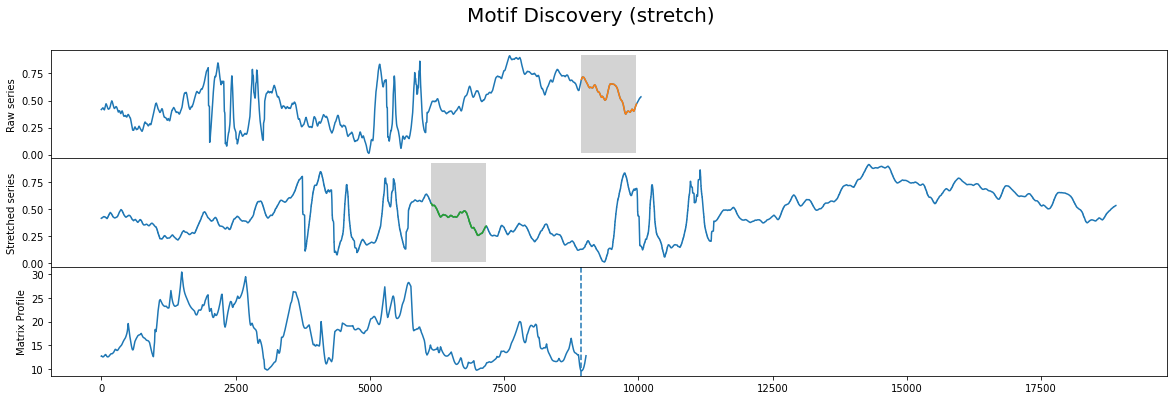

In [29]:
fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery (stretch)', fontsize='20')
axs[0].plot(T)
axs[0].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("Raw series")

axs[1].plot(Ts)
axs[1].plot(x_Ts[idx_min_s:idx_min_s+m], Ts[idx_min_s:idx_min_s+m], color="C2")
rect = Rectangle((idx_min_s, np.min(Ts)), m, np.max(Ts), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].set_ylabel("Stretched series")

axs[2].plot(P_updated)
axs[2].axvline(idx_min, color="C0", linestyle="--")
axs[2].set_ylabel("Matrix Profile")

plt.show()

The best-motif is highlighted orange subsequence from raw dataset (1th panel), and green subsequence from streched sequence by **188%** of raw dataset (2th pannel).  
Those are completly different motif from "normal motif discovery" as you can see below.

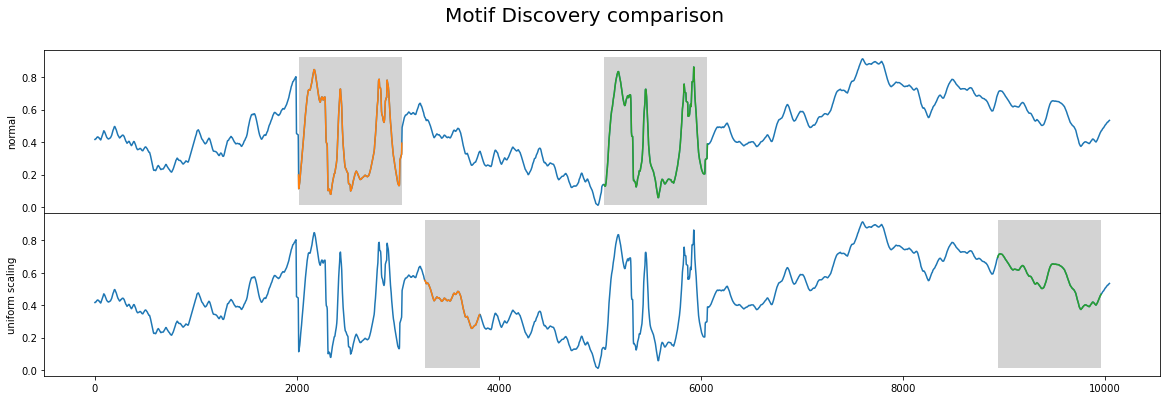

In [30]:
idx_min_s_ = int(idx_min_s/scale_factor)
m_ = int(m/scale_factor)

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery comparison', fontsize='20')
axs[0].plot(T)
axs[0].plot(x[idx_a:idx_a+m], T[idx_a:idx_a+m])
axs[0].plot(x[idx_b:idx_b+m], T[idx_b:idx_b+m])
rect = Rectangle((idx_a, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((idx_b, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("normal")

axs[1].plot(T)
axs[1].plot(x_T[idx_min_s_:idx_min_s_+m_], T[idx_min_s_:idx_min_s_+m_])
rect = Rectangle((idx_min_s_, np.min(T)), m_, np.max(T), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].set_ylabel("uniform scaling")
plt.show()

### 2. Compressing
The searched scaling range is `30% ~ 70%` as an illustrative example.

In [31]:
range_scaling = np.arange(0.3, 0.7, 0.01)
l_ = len(T) - m + 1

P_updated = np.full(l_, np.inf, dtype=np.float64)
I_updated = np.zeros(l_, dtype=np.float64)
minScale = np.full(l_, np.nan, dtype=np.float64)

x_T = np.arange(len(T))
fitted_curve = interpolate.interpolate.interp1d(x_T, T, kind="nearest")

# Search scaling factor
for scale_factor in range_scaling:
    x_dummy = np.linspace(0, len(T)-1, int(len(T)*scale_factor))
    Ts = fitted_curve(x_dummy)

    mp = stumpy.stump(T, m, Ts, ignore_trivial=False)
    mask = mp[:, 0] < P_updated
    P_updated[mask] = mp[mask, 0]
    I_updated[mask] = mp[mask, 1]
    minScale[mask] = scale_factor

idx_min = np.argmin(P_updated)

# shrunk series re-calculation
scale_factor = minScale[idx_min]
x_dummy = np.linspace(0, len(T)-1, int(len(T)*scale_factor))
Ts = fitted_curve(x_dummy)
x_Ts = np.arange(len(Ts))

idx_min_s = int(I_updated[idx_min])

print(f"Best motif is found by scaling factor {scale_factor:.2f}")

Best motif is found by scaling factor 0.44


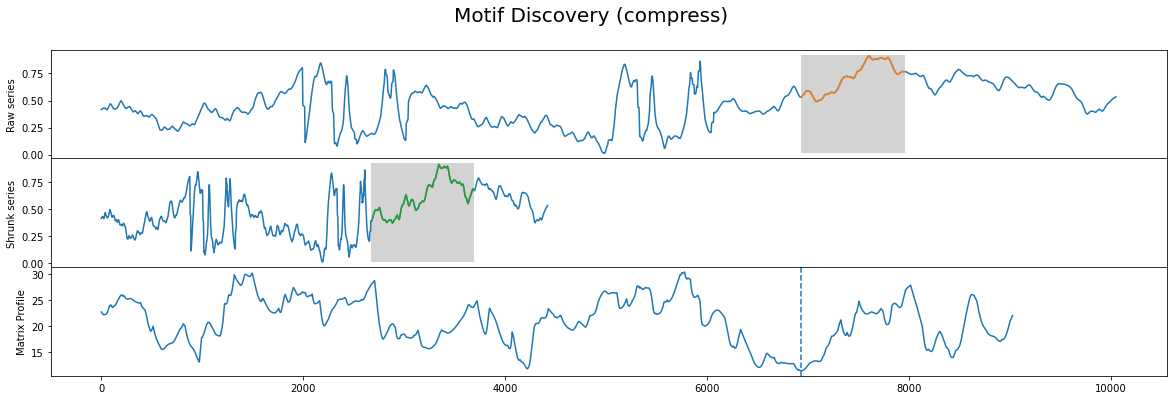

In [32]:
fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery (compress)', fontsize='20')
axs[0].plot(T)
axs[0].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("Raw series")

axs[1].plot(Ts)
axs[1].plot(x_Ts[idx_min_s:idx_min_s+m], Ts[idx_min_s:idx_min_s+m], color="C2")
rect = Rectangle((idx_min_s, np.min(Ts)), m, np.max(Ts), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].set_ylabel("Shrunk series")

axs[2].plot(P_updated)
axs[2].axvline(idx_min, color="C0", linestyle="--")
axs[2].set_ylabel("Matrix Profile")

plt.show()

The best-motif is highlighted orange subsequence from raw dataset (1th panel), and green subsequence from compressed sequence by **44%** of raw dataset (2th pannel).  
Those are completly different motif from "normal motif discovery" as you can see below.

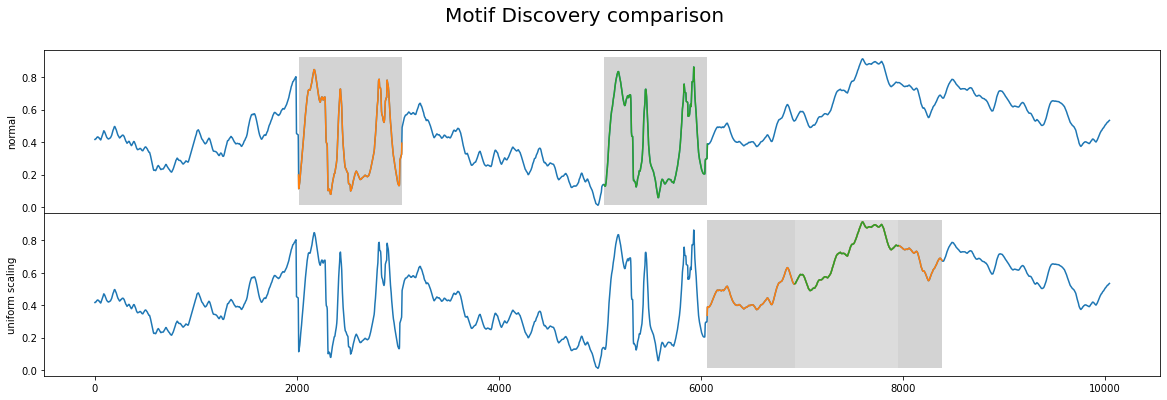

In [33]:
idx_min_s_ = int(idx_min_s/scale_factor)
m_ = int(m/scale_factor)

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery comparison', fontsize='20')
axs[0].plot(T)
axs[0].plot(x[idx_a:idx_a+m], T[idx_a:idx_a+m])
axs[0].plot(x[idx_b:idx_b+m], T[idx_b:idx_b+m])
rect = Rectangle((idx_a, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((idx_b, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("normal")

axs[1].plot(T)
axs[1].plot(x_T[idx_min_s_:idx_min_s_+m_], T[idx_min_s_:idx_min_s_+m_])
axs[1].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min_s_, np.min(T)), m_, np.max(T), facecolor='lightgrey')
axs[1].add_patch(rect)
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='gainsboro')
axs[1].add_patch(rect)
axs[1].set_ylabel("uniform scaling")
plt.show()

Now, the resulting Matrix Profile will discover the motifs with the appropriate uniform scaling invariance.  
To the best of our knowledge, there is only one research effort that has addressed this (Yankov 2007)[2]. However, this method is approximate, requires many parameters to be set,  
and is only able to support a limited range of scaling.  In contrast, we can easily and exactly solve this problem under our simple assumptions.

This example perfectly elucidates the philosophy driving this paper.  
For many time series data mining tasks, we may not need to spend significant human time
designing, implementing and tuning new algorithms.  
The Matrix Profile and ten lines of code may be sufficient.

## References
[1]: [The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do With The Matrix Profile And Ten Lines Of Code](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf) (see Section 3.1)

[2]: Yankov 2007: [Detecting time series motifs under uniform scaling. In: Proceedings of the 2007 ACM SIGKDD](https://dl.acm.org/doi/10.1145/1281192.1281282)  